In [2]:
import torch
import torch.nn as nn
import numpy as np
import argparse
from torchvision import datasets, transforms
from torch.functional import F

import matplotlib.pyplot as plt
import math

import sys
sys.argv=['']
del sys

# Notations
To be consistent with the thesis paper, in the following context, let's denote:

(1). $G = Sp(2n, \mathbb R) = \{A: A^TJA = J\}$, the symplectic group.

(2). $A \in G$, a symplectic matrix.

(3). $X \in \mathfrak{g} = sp(2n,\mathbb{R}) = \{X: (XJ)^T=(XJ)\}$, a matrix in the Lie algebra of $G$.

(4). $Y \in T_AG$, a matrix in the tangent space at $A$.

$A$ and $X$ will be used most of the time.

#Parameters
Under dynamic trivialization, in a general Neural Network combining Symplectic layers and Euclidean layers, we have two kinds of parameters. 

(1). The matrices $X$ in the Lie algebra $\mathfrak{g} \cong T_{e}G$ of the Symplectic layers. 

(2). The parameters $w$ of regular Euclidean layers.

In the following codes, the writer Lezcano denotes 

(1). symplectic Lie algebra matrix $X$ with 'parametrized_params' and 

(2). regular Euclidean parameters $w$ with 'unconstrained_params'.

If we simply want to test the optimization on symplectic group, we shall just use the 'LinearSymplectic' layer (find it below) to build up the test, i.e. we will only have the first kind of parameters $X$.

In [3]:
def get_parameters(model):
    parametrized_params = []

    def get_parametrized_params(mod):
        nonlocal parametrized_params
        if isinstance(mod, ParametrizationImproved):
            parametrized_params.append(mod.X)

    def not_in(elem, l):
        return all(elem is not x for x in l)

    model.apply(get_parametrized_params)

    unconstrained_params = (param for param in model.parameters() if not_in(param, parametrized_params))

    return unconstrained_params, parametrized_params

#Modified Parametrization Class

The following build-up of ParametrizationImproved class makes some modifications to Lezcano's original code.

The main differences are that it must be dynamic trivialization and the K must be some integer between $[1,\infty)$. And it checks whether we are moving in the diffeomorphism region. If not, it will immediatetly stop gradient descent and change the base point using previous point in the tangent space that is still in the diffeomorphism region.

In [4]:
# Parametrization Class

class ParametrizationImproved(nn.Module):
    """
    Implements the parametrization of a manifold in terms of a Euclidean space
    It gives the parametrized matrix through the attribute `A`
    """

    def __init__(self, X, base, K):
        super(ParametrizationImproved, self).__init__()
        self.X = nn.Parameter(X)
        # To see whether the X is in the diffeomorphism region
        # It is useful to check when the X is moving out of the diffeomorphism region 
        # so that one can change the value of K and the learning rate properly.
        self.is_diffeo = None

        # This is necessary, as it will be generated again the first time that self.A is called
        # We still need to register the buffer though
        self.register_buffer("_A", None)
        self.register_buffer('base', base)

        self.k = 0
        self.K = K

        #record the X before gradient descent, useful when moving out of the diffeo region.
        self.X_memo = None  

        # This implements the parametrization trick in a rather slick way.
        # We put a hook on X, such that, whenever its gradients are computed, we
        # get rid of self._A so that it has to be recomputed the next time that
        # self.A is accessed. Also we record the previous point in the tangent space
        # for use if we are moving out of the diffeo region.
        def hook(grad):
            nonlocal self
            self._A = None
            self.X_memo = torch.clone(self.X)
        self.X.register_hook(hook)

    #change the base point
    def rebase(self):
        with torch.no_grad():
            self.base.data.copy_(self._A.data)
            self.X.data.zero_()

    @property
    def A(self):
        not_A = self._A is None
        self.is_diffeo = self.check_diffeo(self.X)
        if not_A or (not self._A.grad_fn and torch.is_grad_enabled()):
            # If X is not in the diffeo region, change the base point immediately.
            # Notice that there can be the situation that the base stops changing from some point.
            # The reason may be that X moves out of diffeo region with only one gradient descent
            # which makes the base get stuck.
            # One should check the value of self.is_diffeo and try some other K or use smaller learning rates.
            if not self.is_diffeo:
                self._A = self.retraction(self.X_memo, self.base)
                # Just to be safe
                self._A.requires_grad_()
                # Now self._A it's not a leaf tensor, so we convert it into a leaf
                self._A.retain_grad()
                self.rebase()
            else:
                self._A = self.retraction(self.X, self.base)
                # Just to be safe
                self._A.requires_grad_()
                # Now self._A it's not a leaf tensor, so we convert it into a leaf
                self._A.retain_grad()
                if not_A:
                    # Change the basis after K optimization steps
                    if self.k == 0:
                        self.rebase()
                    # Increment the counter afterwards as we change the basis in the first iteration 
                    self.k = (self.k + 1) % self.K
        return self._A


    def check_diffeo(self, X):
        '''
        This method check whether X is in the diffeomorphism region.
        It return Ture if it is, otherwise False.
        '''
        raise NotImplementedError


    def retraction(self, X, base):
        """
        It computes r_{base}(X).
        Notice that X will not always be in the tangent space of our manifold
          For this reason, we first have to use X to parametrize the tangent space,
          and then compute the retraction
        When dealing with Lie groups, raw_X is always projected into the Lie algebra, as an optimization (cf. Section E in the paper)
        """
        raise NotImplementedError

    def project(self, base):
        """
        This method is OPTIONAL
        It returns the projected base back into the manifold
        """
        raise NotImplementedError

    def forward(self, input):
        """
        It uses the attribute self.A to implement the layer itself (e.g. Linear, CNN, ...)
        """
        raise NotImplementedError


#Linear Symplectic Layer

This is a simple Linear Symplectic layer.

Input: vector/matrix $v$.

operateion: left multiplication, i.e. $vA$, where $A \in Sp(2n,\mathbb R)$

output: $vA$

(Notice that the function "forward" can be rewritten to produce any other desired structure. In our simple test of optimization, here we just use a very simple linear structure with no bias.)

As the comment of "retraction" in the above Parametrization class, we would expect $X$ to be in $sp(2n, \mathbb{R}) = \{JX+X^TJ = 0\}$. 

Note that for any $Y \in T_AG$, 
\begin{align*}
    \exp_A: T_A G &\to G\\
                Y &\mapsto A\exp(A^{-1}Y) 
\end{align*}

and $T_AG = \{AX: X \in \mathfrak{g}\}$, i.e. $Y = AX$ for some $X \in sp(2n,\mathbb{R})$

Therefore, 
$$\exp_A(Y) = A\exp(A^{-1}Y) = A\exp(A^{-1}AX) = A\exp(X)$$
for $X \in sp(2n,\mathbb{R})$. 

This means that if given A and a parametrization of $sp(2n, \mathbb{R})$, we can calculate the exponential map.

To parametrize $sp(2n,\mathbb{R})$, first notice that 
\begin{align*}
    sp(2n,\mathbb{R}) &= \{X: JX+X^TJ = 0\}\\
                      &= \{X: JX-X^TJ^T = 0\}\\
                      &= \{X: JX-(JX)^T = 0\}\\
                      &= \{X: JX=(JX)^T\}
\end{align*}

So we can first make $JX$ into symmetric matrix and then left multiply $J^{-1} = J^T$ to parametrize $X$, and thus do the parametrization.

In [5]:
#LinearSymplectic

class LinearSymplectic(ParametrizationImproved):
    #input a vector/matrix v, left multiply with symplectic matrix B
    #and output the vector/matrix vB. 
    def __init__(self, size, param, K):
        if size % 2 != 0:
            raise ValueError("Symplectic group is supposed to have size 2n.")
        X = torch.empty(size, size)
        base = torch.empty(size, size)
        super(LinearSymplectic, self).__init__(X, base, K)
        self.size = size
        self.param = param
        self.init_base = nn.init.eye_
        self.init_X = nn.init.zeros_
        self.reset_parameters()

        #set the matrix J of Sp(2n,R)
        n = self.size //2 
        zero = torch.zeros(n,n)
        neg_one = torch.tensor([-1.0 for i in range(n)])
        pos_one = torch.tensor([1.0 for i in range(n)])
        neg_I = torch.diag(neg_one)
        pos_I = torch.diag(pos_one)
        J1 = torch.hstack((zero,pos_I))
        J2 = torch.hstack((neg_I,zero))
        self.J = torch.vstack((J1,J2))

    def reset_parameters(self):
        self.init_X(self.X)
        self.init_base(self.base)
        

    def forward(self, input):
        #this function can be rewritten to produce any other desired structure
        #in our simple test of optimization, here we just use a very simple linear structure with no bias.
        return input.matmul(self.A)


    def retraction(self, X, base):
        '''
        make sure JX is symmetric so that X is in Lie algebra of symplectic group.
        The retraction map is not unique. Any parametrization that makes X in the the Lie algebra can work.
        The one below is another retraction for symplectic group.
        '''
        X = (X + X.t())/2
        X = self.J.mm(X)
        A = base.mm(self.param(X)) 
        return A

    '''
    def retraction(self, X, base):
        #make sure JX is symmetric so that X is in Lie algebra of symplectic group.
        #The retraction map is not unique. Any parametrization that makes X in the the Lie algebra can work.
        JX = self.J.mm(X)
        JX = (JX+JX.t())/2
        X = self.J.t().mm(JX)
        A = base.mm(self.param(X))
        return A
    '''

    def check_diffeo(self, X):
        is_diffeo = True
        X = (X + X.t())/2
        X = self.J.mm(X)
        eigenvalues = torch.linalg.eigvals(X)
        for eigenvalue in eigenvalues:
            if eigenvalue.imag >= np.pi:
                is_diffeo = False
        return is_diffeo

#Trivialization

Here we shall just put emphasis on the expm class.

In [6]:
# trivializations

def cayley_map(A):
    n = A.size(0)
    Id = torch.eye(n, dtype=X.dtype, device=A.device)
    return torch.solve(Id - A, Id + A)[0]

class expm_class(torch.autograd.Function):
    @staticmethod
    def forward(ctx, X):
        ctx.save_for_backward(X)
        return expm32(X)

    @staticmethod
    def backward(ctx, G):
        (X,) = ctx.saved_tensors
        return differential(expm32, X.t(), G)

expm = expm_class.apply

# Matrix Exponential and the Differential

'expm32' calculates the matrix exponential.

'differential' computes the differential of $f$ at $A$ when acting on $E$: $(df)_A(E)$



In [7]:
# matrx exponential and differential 

"""
Adaptation of expm and expm_frechet in numpy for torch
"""

#
# Authors: Travis Oliphant, March 2002
#          Anthony Scopatz, August 2012 (Sparse Updates)
#          Jake Vanderplas, August 2012 (Sparse Updates)
#

from __future__ import division, print_function, absolute_import

import math

import numpy as np

import torch
import scipy.special

def _onenorm_matrix_power_nnm(A, p):
    """
    Compute the 1-norm of a non-negative integer power of a non-negative matrix.
    Parameters
    ----------
    A : a square ndarray or matrix or sparse matrix
        Input matrix with non-negative entries.
    p : non-negative integer
        The power to which the matrix is to be raised.
    Returns
    -------
    out : float
        The 1-norm of the matrix power p of A.
    """
    # check input
    if int(p) != p or p < 0:
        raise ValueError('expected non-negative integer p')
    p = int(p)
    if len(A.shape) != 2 or A.shape[0] != A.shape[1]:
        raise ValueError('expected A to be like a square matrix')

    # Explicitly make a column vector so that this works when A is a
    # numpy matrix (in addition to ndarray and sparse matrix).
    v = torch.ones((A.shape[0], 1), dtype=A.dtype, device=A.device)
    M = A.t()
    for _ in range(p):
        v = M.mm(v)
    return torch.max(v).item()


def _onenorm(A):
    return torch.norm(A, 1).item()


def _ident_like(A):
    return torch.eye(A.shape[0], A.shape[1], dtype=A.dtype, device=A.device)

class _ExpmPadeHelper(object):
    """
    Help lazily evaluate a matrix exponential.
    The idea is to not do more work than we need for high expm precision,
    so we lazily compute matrix powers and store or precompute
    other properties of the matrix.
    """
    def __init__(self, A):
        """
        Initialize the object.
        Parameters
        ----------
        A : a dense or sparse square numpy matrix or ndarray
            The matrix to be exponentiated.
        """
        self.A = A
        self._A2 = None
        self._A4 = None
        self._A6 = None
        self._A8 = None
        self._A10 = None
        self._d4_exact = None
        self._d6_exact = None
        self._d8_exact = None
        self._d10_exact = None
        self._d4_approx = None
        self._d6_approx = None
        self._d8_approx = None
        self._d10_approx = None
        self.ident = _ident_like(A)

    @property
    def A2(self):
        if self._A2 is None:
            self._A2 = self.A.mm(self.A)
        return self._A2

    @property
    def A4(self):
        if self._A4 is None:
            self._A4 = self.A2.mm(self.A2)
        return self._A4

    @property
    def A6(self):
        if self._A6 is None:
            self._A6 = self.A4.mm(self.A2)
        return self._A6

    @property
    def A8(self):
        if self._A8 is None:
            self._A8 = self.A6.mm(self.A2)
        return self._A8

    @property
    def A10(self):
        if self._A10 is None:
            self._A10 = self.A4.mm(self.A6)
        return self._A10

    @property
    def d4_tight(self):
        if self._d4_exact is None:
            self._d4_exact = _onenorm(self.A4)**(1/4.)
        return self._d4_exact

    @property
    def d6_tight(self):
        if self._d6_exact is None:
            self._d6_exact = _onenorm(self.A6)**(1/6.)
        return self._d6_exact

    @property
    def d8_tight(self):
        if self._d8_exact is None:
            self._d8_exact = _onenorm(self.A8)**(1/8.)
        return self._d8_exact

    @property
    def d10_tight(self):
        if self._d10_exact is None:
            self._d10_exact = _onenorm(self.A10)**(1/10.)
        return self._d10_exact

    @property
    def d4_loose(self):
        return self.d4_tight

    @property
    def d6_loose(self):
        return self.d6_tight

    @property
    def d8_loose(self):
        return self.d8_tight

    @property
    def d10_loose(self):
        return self.d10_tight

    def pade3(self):
        b = (120., 60., 12., 1.)
        U = self.A.mm(b[3]*self.A2 + b[1]*self.ident)
        V = b[2]*self.A2 + b[0]*self.ident
        return U, V

    def pade5(self):
        b = (30240., 15120., 3360., 420., 30., 1.)
        U = self.A.mm(b[5]*self.A4 + b[3]*self.A2 + b[1]*self.ident)
        V = b[4]*self.A4 + b[2]*self.A2 + b[0]*self.ident
        return U, V

    def pade7_scaled(self, s):
        b = (17297280., 8648640., 1995840., 277200., 25200., 1512., 56., 1.)

        B = self.A * 2**-s
        B2 = self.A2 * 2**(-2*s)
        B4 = self.A4 * 2**(-4*s)
        B6 = self.A6 * 2**(-6*s)

        U = B.mm(b[7]*B6 + b[5]*B4 + b[3]*B2 + b[1]*self.ident)
        V = b[6]*B6 + b[4]*B4 + b[2]*B2 + b[0]*self.ident
        return U, V


def expm32(A):
    """
    Compute the matrix exponential using Pade approximation.
    Parameters
    ----------
    A : (M,M) array_like or sparse matrix
        2D Array or Matrix (sparse or dense) to be exponentiated
    Returns
    -------
    expA : (M,M) ndarray
        Matrix exponential of `A`
    Notes
    -----
    This is algorithm (6.1) which is a simplification of algorithm (5.1).
    .. versionadded:: 0.12.0
    References
    ----------
    .. [1] Awad H. Al-Mohy and Nicholas J. Higham (2009)
           "A New Scaling and Squaring Algorithm for the Matrix Exponential."
           SIAM Journal on Matrix Analysis and Applications.
           31 (3). pp. 970-989. ISSN 1095-7162
    """
    return _expm(A)


def _expm(A):
    # Core of expm, separated to allow testing exact and approximate
    # algorithms.

    # Avoid indiscriminate asarray() to allow sparse or other strange arrays.
    if len(A.shape) != 2 or A.shape[0] != A.shape[1]:
        raise ValueError('expected a square matrix')

    # Trivial case
    if A.shape == (1, 1):
        return torch.exp(A)

    # Track functions of A to help compute the matrix exponential.
    h = _ExpmPadeHelper(A)

    # Try Pade order 3.
    eta_1 = max(h.d4_loose, h.d6_loose)
    theta3 = 4.2587300348979312e-001
    if eta_1 < theta3 and _ell(h.A, 3) == 0:
        U, V = h.pade3()
        return _solve_P_Q(U, V)

    # Try Pade order 5.
    eta_2 = max(h.d4_tight, h.d6_loose)
    theta5 = 1.8801526985337688e+000
    if eta_2 < theta5 and _ell(h.A, 5) == 0:
        U, V = h.pade5()
        return _solve_P_Q(U, V)

    theta_7 = 3.9257248464332842e+000
    eta_3 = max(h.d6_tight, h.d8_loose)
    s = max(int(np.ceil(np.log2(eta_3 / theta_7))), 0)

    s += _ell(2**-s * h.A, 7)
    U, V = h.pade7_scaled(s)
    X = _solve_P_Q(U, V)
    return torch.matrix_power(X, 2**s)


def _solve_P_Q(U, V):
    P = U + V
    Q = -U + V
    return torch.linalg.solve(P, Q)


def _ell(A, m):
    """
    A helper function for expm_2009.
    Parameters
    ----------
    A : linear operator
        A linear operator whose norm of power we care about.
    m : int
        The power of the linear operator
    Returns
    -------
    value : int
        A value related to a bound.
    """
    if len(A.shape) != 2 or A.shape[0] != A.shape[1]:
        raise ValueError('expected A to be like a square matrix')

    p = 2*m + 1

    # The c_i are explained in (2.2) and (2.6) of the 2005 expm paper.
    # They are coefficients of terms of a generating function series expansion.
    choose_2p_p = scipy.special.comb(2*p, p, exact=True)
    abs_c_recip = float(choose_2p_p * math.factorial(2*p + 1))

    # This is explained after Eq. (1.2) of the 2009 expm paper.
    # It is the "unit roundoff" of IEEE double precision arithmetic.
    u = 2.**-24

    # Compute the one-norm of matrix power p of abs(A).
    A_abs_onenorm = _onenorm_matrix_power_nnm(abs(A), p)

    # Treat zero norm as a special case.
    if not A_abs_onenorm:
        return 0

    alpha = A_abs_onenorm / (_onenorm(A) * abs_c_recip)
    return max(int(np.ceil(np.log2(alpha/u) / (2 * m))), 0)

def differential(f, A, E):
    """ Computes the differential of f at A when acting on E:  (df)_A(E) """
    n = A.size(0)
    M = torch.zeros(2*n, 2*n, dtype=A.dtype, device=A.device, requires_grad=False)
    M[:n, :n] = A
    M[n:, n:] = A
    M[:n, n:] = E
    return f(M)[:n, n:]

# Simple Test(Vanilla)

We first generate a fixed symplectic matrix $G$. Then we generated some random vectors $v$. Through a right multiplication by $G$, we also generate the labels $y = vG$.

Now we feed the generated $v$ and $y$ into the LinearSymplectic layer and train the model. Thus the optimization problem is 
$$
\min\limits_{A \in Sp(2n,\mathbb{R})}\mathbb{E}[||vA-y||^2]
$$
where $||.||$ is the vector norm.

The exact solution should be the G we created, and we expect the result to be close to G.

##Defalut setting, K=10, vanilla epoch 3000, batch epoch 300, learning rate 0.05

In [8]:
# test_main
parser = argparse.ArgumentParser(description='Linear Symplectic Layer Simple Task')
#parser.add_argument('--batch_size', type=int, default=32)
#parser.add_argument('--hidden_size', type=int, default=170)
parser.add_argument('--epochs', type=int, default=3000)
parser.add_argument('--epochs2', type=int, default=300)
#parser.add_argument('--lr', type=float, default=1e-2)
parser.add_argument('--lr_symp', type=float, default=5e-2)
parser.add_argument("--permute", action="store_true")
parser.add_argument('--K', type=str, default="10", help='The K parameter in the dtriv algorithm. It should be a positive integer.')


args = parser.parse_args()

#batch_size  = args.batch_size
#hidden_size = args.hidden_size
epochs      = args.epochs
epochs2     = args.epochs2
device      = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
args.K      = int(args.K)


## Data

In [9]:
input_size = 4
np.random.seed(0)

G = [[ 1.,   3.,   1.,   0. ],
     [ 2.,   4., -2.5,  1.5],
     [ 0.,   0.,  -2.,   1. ],
     [ 0.,   0.,   1.5, -0.5]]

n = 1000

V = []
y = []
for i in range(n):
    v = np.random.rand(4) # change to random vector
    V.append(v)
    y.append(v.dot(G) )


##Test Model 1, K=10, learning rate=0.005

In [11]:
losses_1 = []

class test_Model(nn.Module):
    def __init__(self, input_size):
        super(test_Model, self).__init__()
        self.symp = LinearSymplectic(input_size, param=expm, K=args.K)
        self.loss_func = nn.MSELoss()

    def forward(self, input): 
        l = self.symp(input)
        return l

    def loss(self, preds, y):
        return self.loss_func(preds, y)

def main():
    model = test_Model(input_size).to(device)
    model.train()
    non_symp_params, log_symp_params = get_parameters(model)
    #optim = torch.optim.Adam(non_symp_params, args.lr)
    optim_symp = torch.optim.Adam(log_symp_params, lr=5e-3)

    for epoch in range(10000):
        preds = model(torch.tensor(V).float())
        loss = model.loss(preds, torch.tensor(y).float())
        loss.backward()
        #if optim.step():
            #optim.step()
        if optim_symp:
            optim_symp.step()

        #if optim.zero_grad():
            #optim.zero_grad()
        if optim_symp:
            optim_symp.zero_grad()
        losses_1.append(loss)

        # One had better keep tracking the diffeomorphism condition during the optimization.
        print(model.symp.is_diffeo)
        print("Iter {}: Loss= {:.6f}".format(epoch, loss))

        #break the gradient descent if the loss is under the certain level to avoid the fluctuation at later stage.
        if loss <= 1e-10:
          break

    print("Optimization Finished!")
    model.eval()
    print("The resulted symplectic matrix is:")
    print(model.symp.A)


if __name__ == "__main__":
    main()

流式输出内容被截断，只能显示最后 5000 行内容。
Iter 7055: Loss= 0.000262
True
Iter 7056: Loss= 0.000261
True
Iter 7057: Loss= 0.000260
True
Iter 7058: Loss= 0.000260
True
Iter 7059: Loss= 0.000259
True
Iter 7060: Loss= 0.000258
True
Iter 7061: Loss= 0.000257
True
Iter 7062: Loss= 0.000257
True
Iter 7063: Loss= 0.000256
True
Iter 7064: Loss= 0.000255
True
Iter 7065: Loss= 0.000254
True
Iter 7066: Loss= 0.000253
True
Iter 7067: Loss= 0.000253
True
Iter 7068: Loss= 0.000252
True
Iter 7069: Loss= 0.000251
True
Iter 7070: Loss= 0.000250
True
Iter 7071: Loss= 0.000249
True
Iter 7072: Loss= 0.000249
True
Iter 7073: Loss= 0.000248
True
Iter 7074: Loss= 0.000247
True
Iter 7075: Loss= 0.000246
True
Iter 7076: Loss= 0.000246
True
Iter 7077: Loss= 0.000245
True
Iter 7078: Loss= 0.000244
True
Iter 7079: Loss= 0.000243
True
Iter 7080: Loss= 0.000243
True
Iter 7081: Loss= 0.000242
True
Iter 7082: Loss= 0.000241
True
Iter 7083: Loss= 0.000240
True
Iter 7084: Loss= 0.000240
True
Iter 7085: Loss= 0.000239
True
Iter 7086: L

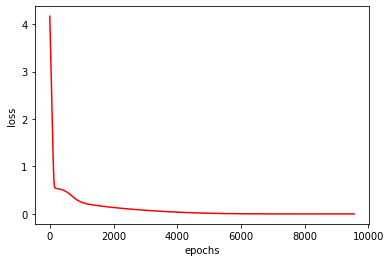

In [12]:
plt.plot(losses_1,'r')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

#Mini Batch

In [15]:
batch_losses = []

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
data = TensorDataset(torch.tensor(V).float(),torch.tensor(y).float())
dataloader =  DataLoader(data,batch_size = 32, shuffle=True)
def main(train_dl, loss_func=nn.MSELoss()):
    model = test_Model(input_size).to(device)
    model.train()

    non_symp_params, log_symp_params = get_parameters(model)
    #optim = torch.optim.Adam(non_symp_params, args.lr)
    optim_symp = torch.optim.Adam(log_symp_params, lr=5e-3)
    # using decreasing learning rate lr=lr*0.997**epoch
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim_symp, gamma=0.997)

    for epoch in range(3000):
        train_losses = []
        for step, (x, y) in enumerate(train_dl):

            prediction = model(x.to(device))

            loss = loss_func(prediction, y.to(device))
            loss.backward()

            #optim.step()
            if optim_symp:
                optim_symp.step()

            #optim.zero_grad()
            if optim_symp:
                optim_symp.zero_grad()
            train_losses.append(loss.item())
        
        scheduler.step()
        batch_losses.append(np.mean(train_losses))
        print("Iter {}: Loss= {:.6f}".format(epoch, np.mean(train_losses)))
        #print(model.symp.A)
        if loss <= 1e-10:
          break

    print("Optimization Finished!")
    model.eval()
    print(model.symp.A)

main(dataloader)

Iter 0: Loss= 3.704917
Iter 1: Loss= 2.838585
Iter 2: Loss= 1.952218
Iter 3: Loss= 1.096215
Iter 4: Loss= 0.629997
Iter 5: Loss= 0.544361
Iter 6: Loss= 0.537843
Iter 7: Loss= 0.531388
Iter 8: Loss= 0.530295
Iter 9: Loss= 0.527321
Iter 10: Loss= 0.525128
Iter 11: Loss= 0.520900
Iter 12: Loss= 0.516333
Iter 13: Loss= 0.504431
Iter 14: Loss= 0.504139
Iter 15: Loss= 0.489270
Iter 16: Loss= 0.484246
Iter 17: Loss= 0.483835
Iter 18: Loss= 0.476409
Iter 19: Loss= 0.457632
Iter 20: Loss= 0.450956
Iter 21: Loss= 0.445761
Iter 22: Loss= 0.427739
Iter 23: Loss= 0.418464
Iter 24: Loss= 0.408220
Iter 25: Loss= 0.390913
Iter 26: Loss= 0.387539
Iter 27: Loss= 0.376835
Iter 28: Loss= 0.359289
Iter 29: Loss= 0.350351
Iter 30: Loss= 0.338479
Iter 31: Loss= 0.333543
Iter 32: Loss= 0.326080
Iter 33: Loss= 0.315231
Iter 34: Loss= 0.307442
Iter 35: Loss= 0.302716
Iter 36: Loss= 0.291890
Iter 37: Loss= 0.286905
Iter 38: Loss= 0.281048
Iter 39: Loss= 0.275018
Iter 40: Loss= 0.271217
Iter 41: Loss= 0.262347
It

##Comparison between Vanilla and MiniBatch

In [ ]:
x_0_300 = np.arange(0,300)
plt.plot(losses_1[0:300], 'r', label="Vanilla")
plt.plot(batch_losses[0:300], 'b', label='MiniBatch')

plt.xlabel('epochs')
plt.ylabel('loss')

plt.legend()
plt.show()

In [ ]:
x_150_300 = np.arange(200,300)
plt.plot(x_150_300,batch_losses[200:300], 'b', label='MiniBatch 32')

plt.xlabel('epochs')
plt.ylabel('loss')

plt.legend()
plt.show()